In [87]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [88]:
import kagglehub
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone
%matplotlib inline

In [89]:
path = kagglehub.dataset_download("itsmesunil/bank-loan-modelling")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Minfy\.cache\kagglehub\datasets\itsmesunil\bank-loan-modelling\versions\1


In [90]:
xls = pd.ExcelFile(f'{path}/Bank_Personal_Loan_Modelling.xlsx')
print("Available sheets:", xls.sheet_names)

Available sheets: ['Description', 'Data']


In [91]:
df = pd.read_excel(xls, sheet_name='Data')

In [92]:
df.rename(columns={'Personal Loan': 'Defaulter'}, inplace=True)

In [93]:
df.head()

ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Defaulter  Securities Account  CD Account  Online  CreditCard  
0          0                   1           0       0           0  
1          0                   1           0       0           0  
2          0                   0           0       0           0  
3          0                   0           0       0           0  
4          0                   0           0       0           1

In [94]:
import sweetviz as sv

In [95]:
report = sv.analyze([df, "Full Data"], target_feat="Defaulter")
report.show_html("loan_analysis_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report loan_analysis_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [96]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 186.58it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [97]:
#DROPPING THE COLUMN ID AS IT CONTAINS THE LEAST INFORMATION
df.drop('ID', axis=1, inplace=True) 

In [98]:
#CORELATION
royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
royalblue_r = royalblue.reversed()

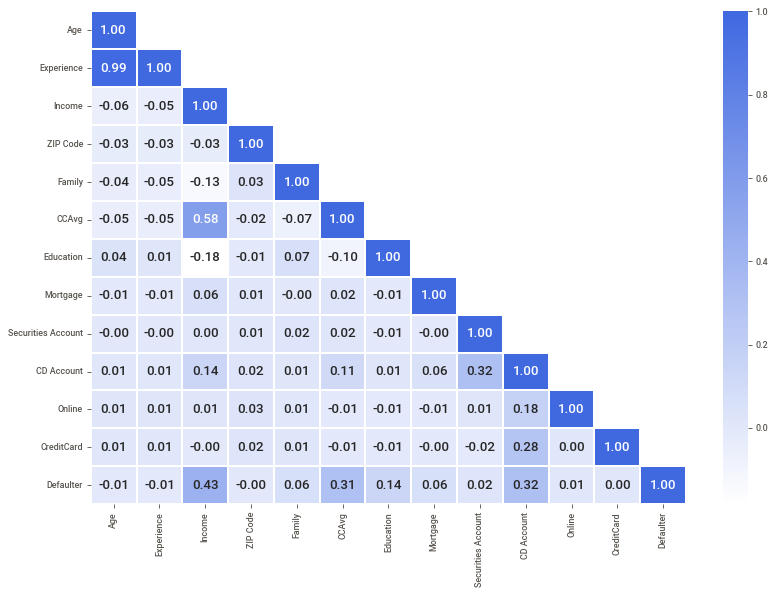

In [99]:
# CO-RELATION USING Sprearmen
target = 'Defaulter'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr(method='spearman')

plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

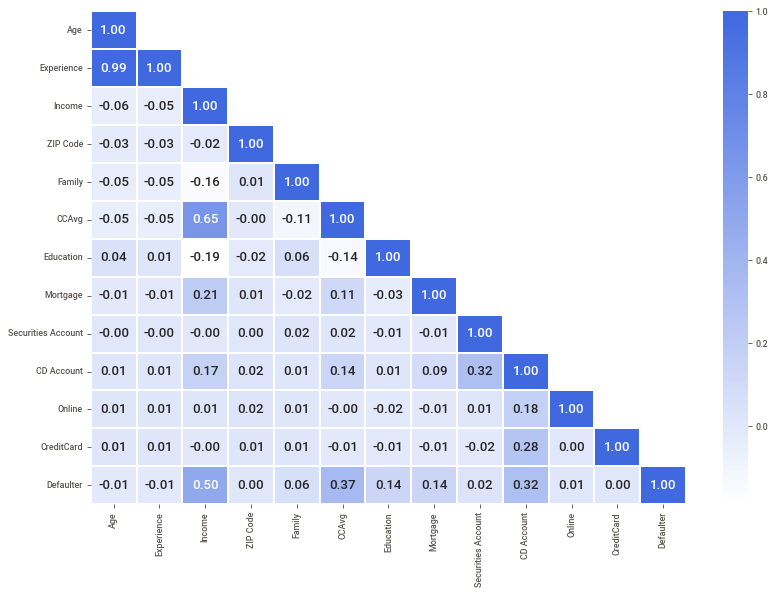

In [100]:
# CO-RELATION USING DEFAULT PARAMETER WHICH IS PEARSON
target = 'Defaulter'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr()

plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(corr, mask=mask, annot=True, cmap=royalblue, fmt='.2f', linewidths=0.2)
plt.show()

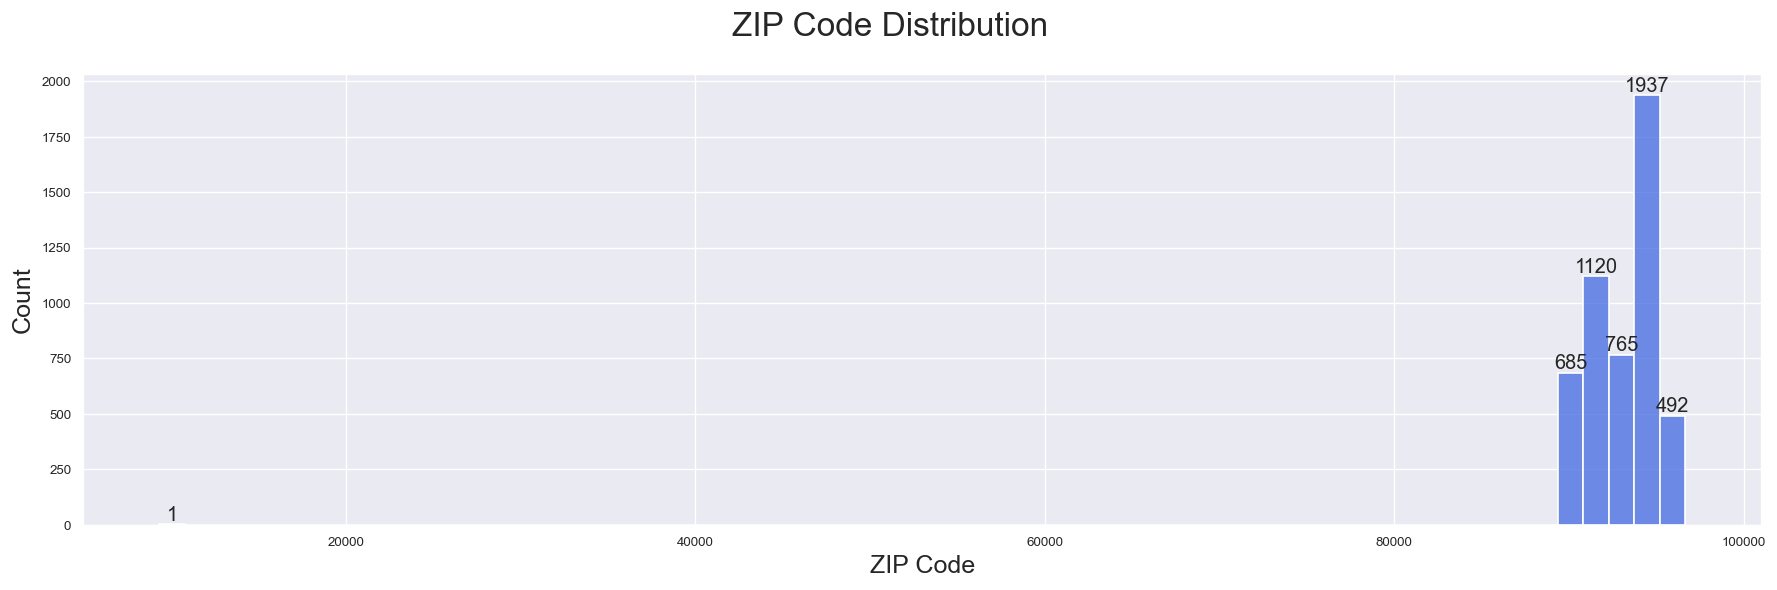

In [101]:

sns.set_style('darkgrid')
color = 'royalblue'

plt.figure(figsize=(15,5), dpi=120)
graph = sns.histplot(x='ZIP Code', data=df, bins=60, color=color)

# Show non-zero values of the individual bars
labels = [str(v) if v else '' for v in graph.containers[0].datavalues]
graph.bar_label(graph.containers[0], labels=labels)
plt.xlabel('ZIP Code', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.suptitle('ZIP Code Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [102]:
df[df['ZIP Code']<20000]

Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
384   51          25      21      9307       4    0.6          3         0   

     Defaulter  Securities Account  CD Account  Online  CreditCard  
384          0                   0           0       1           1

In [103]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

In [104]:
df[df['Experience']<0]['Experience'].count()

52

In [105]:
df[df['Experience']<0]['Experience'].value_counts()

Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

In [106]:
df['Experience'] = df['Experience'].apply(abs)

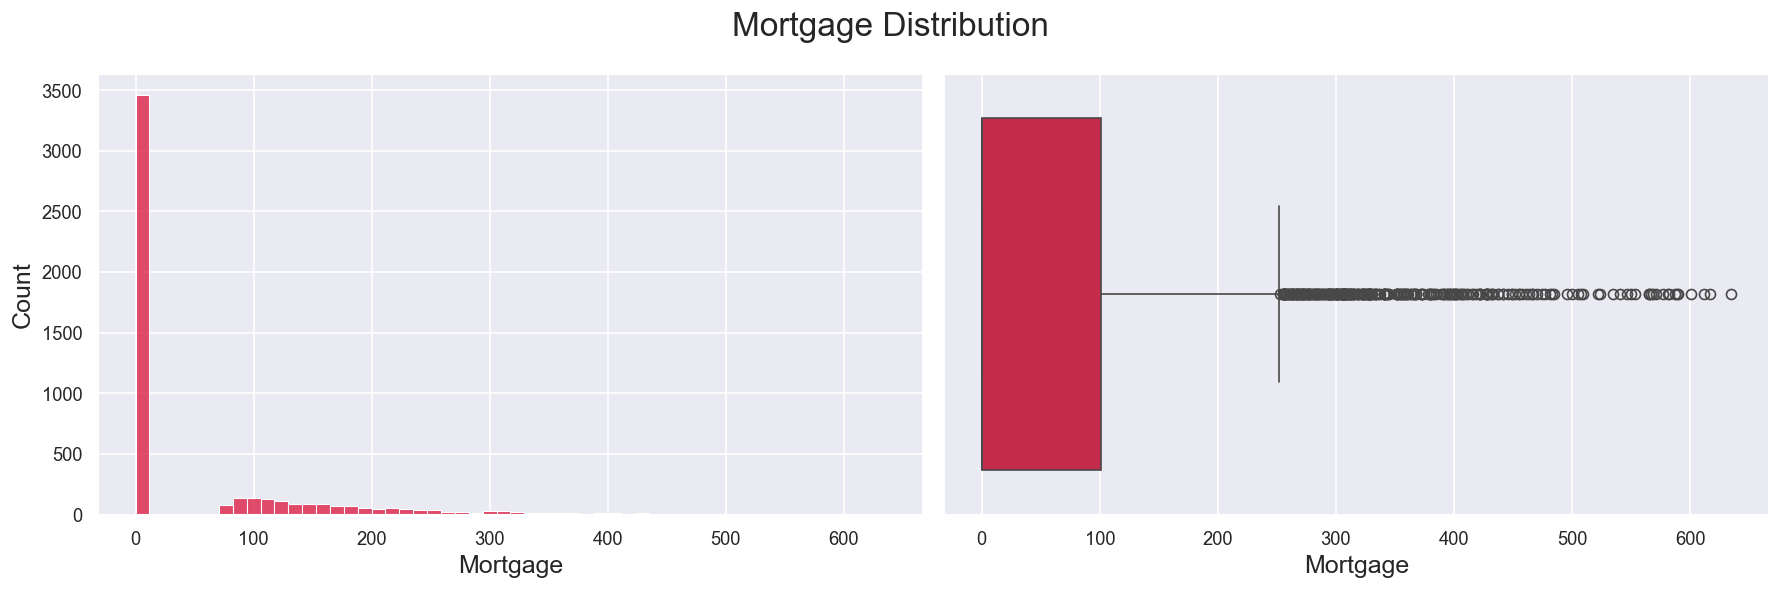

In [107]:
sns.set(rc = {'axes.labelsize' : 15})               
fig, ax = plt.subplots(1, 2, figsize=(15,5), dpi=120)
sns.histplot(x='Mortgage', data=df, color='crimson', ax=ax[0])
sns.boxplot(x='Mortgage', data=df, color='crimson', ax=ax[1])
plt.suptitle('Mortgage Distribution', fontsize=20)
plt.tight_layout()
plt.show()

In [108]:
#z-SCORE OF MORTGAGE
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

In [109]:
#OUTLIERS
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

In [110]:
#MISSING VALUES
df.isnull().sum()

Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Defaulter             0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [111]:
#DUPLICATE VALUES
df[df.duplicated(keep=False)].sum()

Age                   0.0
Experience            0.0
Income                0.0
ZIP Code              0.0
Family                0.0
CCAvg                 0.0
Education             0.0
Mortgage              0.0
Defaulter             0.0
Securities Account    0.0
CD Account            0.0
Online                0.0
CreditCard            0.0
dtype: float64

In [112]:
#CONVERTING THE CCAVG BECAUSE THE INCOME IS MENTIONED IN YEARS
df['CCAvg'] = df['CCAvg']*12

In [113]:
#CATEGORICAL FEATURES VS TARGET
cat_features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']
target = 'Defaulter'


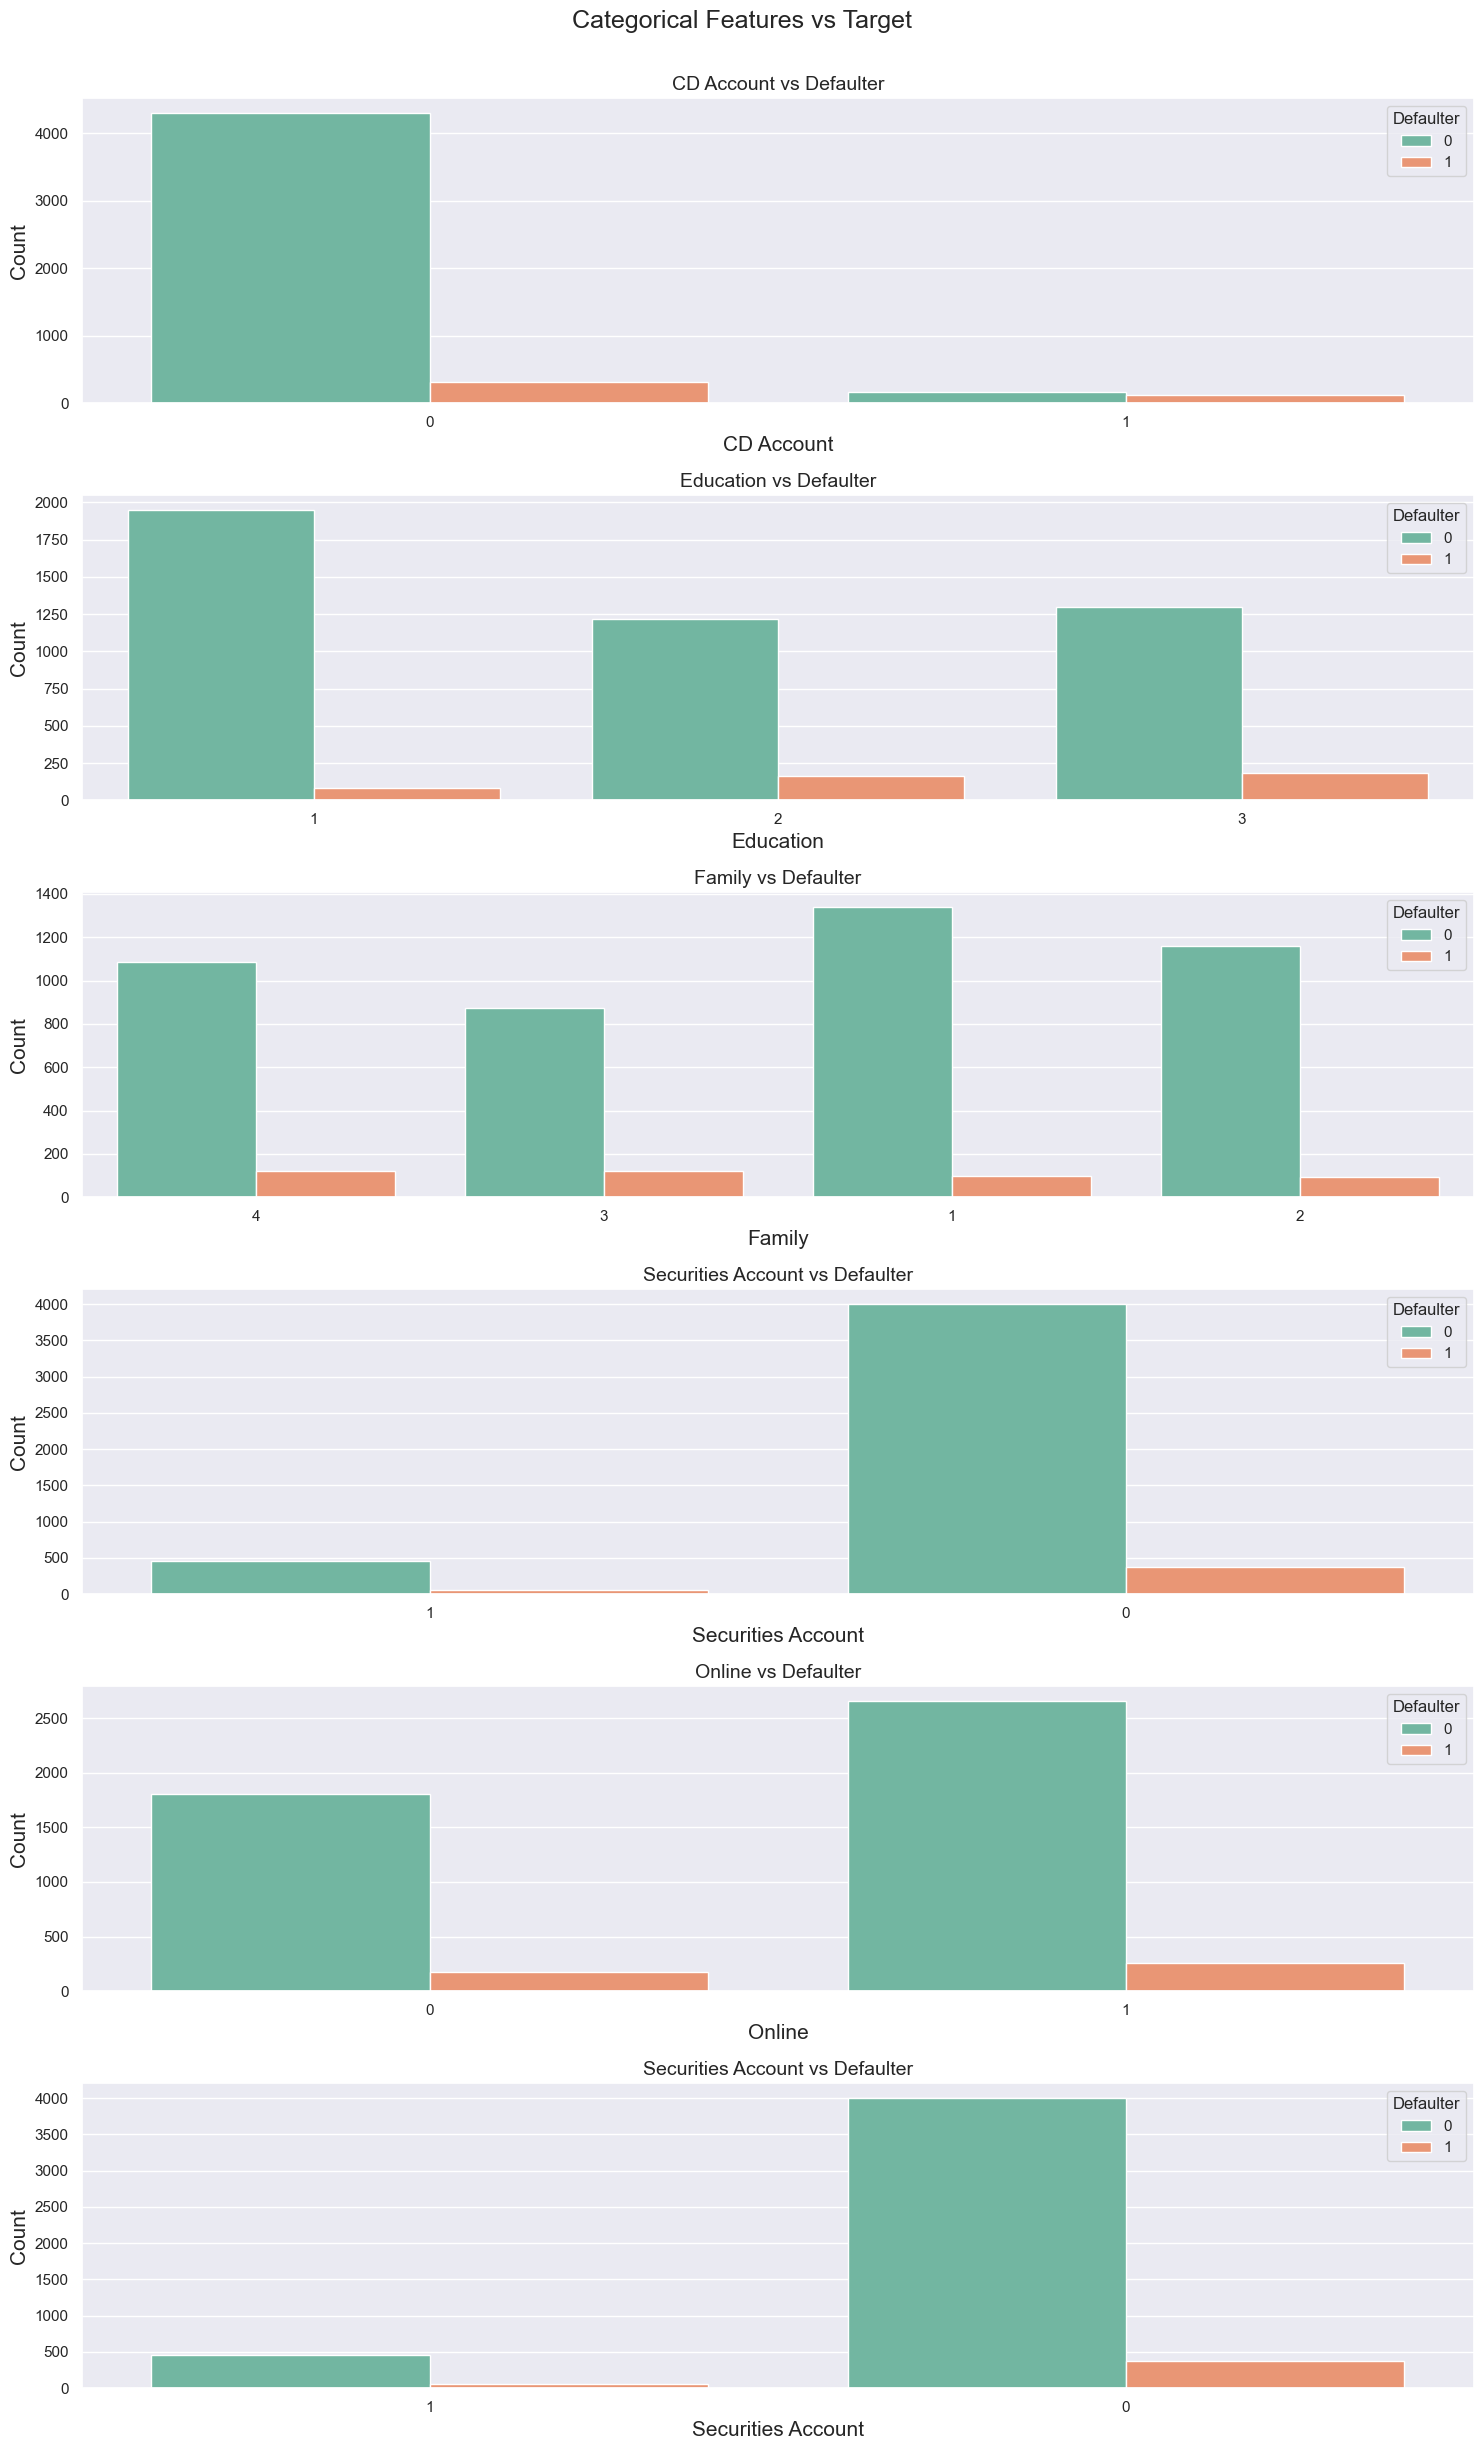

In [114]:
def plot_cat_features_vs_target(df, cat_features, target):
    plt.figure(figsize=(15, len(cat_features) * 4))
    
    for i, col in enumerate(cat_features, 1):
        plt.subplot(len(cat_features), 1, i)

        # Convert to string if binary or small-category
        if df[col].nunique() <= 5:
            df[col] = df[col].astype(str)
        
        # Fill missing values
        df[col] = df[col].fillna("Missing")
        
        sns.countplot(data=df, x=col, hue=target, palette='Set2')
        plt.title(f"{col} vs {target}", fontsize=14)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.legend(title=target)
        plt.tight_layout()
    
    plt.suptitle("Categorical Features vs Target", fontsize=18, y=1.02)
    plt.show()
plot_cat_features_vs_target(df, cat_features, target)


In [115]:
#TRAIN TEST SPLIT
X = df.drop('Defaulter', axis=1)
y = df['Defaulter'] 

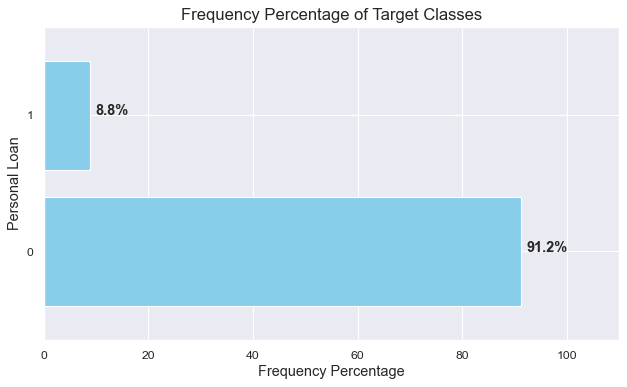

In [116]:
# Calculate frequency percentages of each target class
percentages = df['Defaulter'].value_counts(normalize=True).mul(100).round(1)

# Create the plot
plt.figure(figsize=(8, 5), dpi=80)
percentages.plot(kind='barh', width=0.8, color='skyblue')

# Add text labels to the bars
for i in percentages.index:
    plt.text(percentages[i] + 1, i, f"{percentages[i]}%", fontsize=13, weight='bold')

# Set axis limits and labels
plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel('Personal Loan', fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=15)

# Display the plot
plt.tight_layout()
plt.show()

In [134]:
# Convert binary categorical columns to integer explicitly
binary_cols = ['Securities Account', 'CD Account', 'Online', 'CreditCard']
df[binary_cols] = df[binary_cols].astype(int)

In [135]:
# --- Tune discretization ---
cols = ['Age', 'Income', 'CCAvg', 'Mortgage']
X_disc = df[cols]
y_disc = df['Defaulter']
X_train_disc, _, y_train_disc, _ = train_test_split(X_disc, y_disc, test_size=0.2, stratify=y_disc, random_state=0)

param_grid = {
    'discretizer__strategy': ['uniform', 'quantile', 'kmeans'],
    'discretizer__n_bins': np.arange(2, 11)
}

pipeline = Pipeline([
    ('discretizer', KBinsDiscretizer(encode='ordinal')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')),
    ('clf', ComplementNB())
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1')
grid_search.fit(X_train_disc, y_train_disc)
n_bins = grid_search.best_params_['discretizer__n_bins']
strategy = grid_search.best_params_['discretizer__strategy']

C:\Users\Minfy\anaconda3\envs\virtualEnvironment\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\Minfy\anaconda3\envs\virtualEnvironment\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\Minfy\anaconda3\envs\virtualEnvironment\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C

In [136]:
# --- Transform features ---
cols_to_discretize = ['Age', 'Income', 'CCAvg', 'Mortgage']
cols_to_encode = ['Age', 'Income', 'CCAvg', 'Mortgage', 'Family', 'Education']

X = df.drop('Defaulter', axis=1)
y = df['Defaulter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

discretizer = KBinsDiscretizer(n_bins=n_bins, strategy=strategy, encode='ordinal')
X_train[cols_to_discretize] = discretizer.fit_transform(X_train[cols_to_discretize])
X_test[cols_to_discretize] = discretizer.transform(X_test[cols_to_discretize])

X_train = pd.get_dummies(X_train, columns=cols_to_encode, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cols_to_encode, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

C:\Users\Minfy\anaconda3\envs\virtualEnvironment\Lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [137]:
# --- Train XGBoost ---
ratio = sum(y_train == 0) / sum(y_train == 1)
model = XGBClassifier(
    max_depth=5,
    learning_rate=0.2,
    n_estimators=200,
    scale_pos_weight=ratio,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=0,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)


Evaluation Report for Primary XGBoost:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.91      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



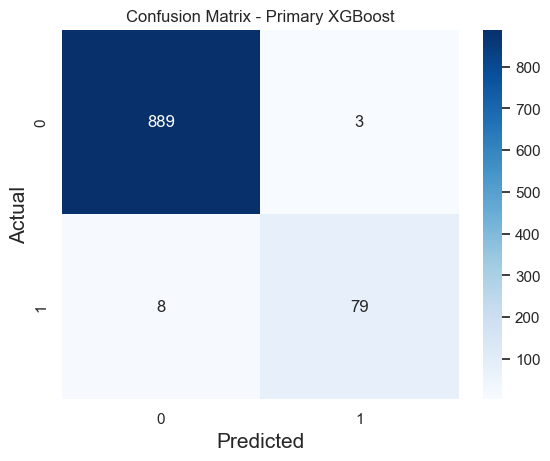

ROC AUC Score: 0.9799
Training Accuracy: 1.0000
Validation Accuracy: 0.9888
ROC AUC Score for Primary XGBoost: 0.9799


In [143]:

# --- Evaluate model ---
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
y_pred = model.predict(X_test)
print("\nEvaluation Report for Primary XGBoost:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Primary XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {auc_score:.4f}")

train_acc = accuracy_score(y_train, model.predict(X_train))
val_acc = accuracy_score(y_test, y_pred)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

auc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score for Primary XGBoost: {auc_score:.4f}")